## IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn import preprocessing

## LOADING & EXPLORING DATA

1- bookID count shows 11127 rows (describe function) but highest bookID is 45641 (= it is an ID number, not a count)

2- removed unwanted commas separating several authors in Author column. As only 4 books were concerned it was done manually.

3- noticed special characters (jpn, chn, ar) in the authors names : no matter as this column author, although relevant, shall be removed due to difficulties in selecting the "right" author to work on for rating influence

4- isbn column: 

    - should be 10-digit long as "isbn10" standard number (before 2007)
    
    - a large number of rows have 7, 8, 9 digits or even 10 with an X at the end: should be dropped as it does not bring much help for our purpose 

5- isbn13 column (REFERENCE number since 2007):

    - should be 13-digit long as "isbn13" standard number

    - 10, 11 digit number --> should be dropped as it does not bring much help for our purpose 

6- "language code": english in 4 or 5 different versions (eg: en-GB, en-US, etc.): MAY NEED GROUPING BOOKS IN ENGLISH OR CREATE CATEGORIES TO IMPROVE PREDICTION (LIKE ENGLISH VS OTHER LANGUAGES)

7- "num_pages": books from 0 up to 6576 pages --> NEED FILTERING (as potential non-relevant outliers) BY DEFINING A "MIN/MAX NUM_PAGES" OR CREATE CATEGORIES TO IMPROVE PREDICTION

8- "Ratings count": from 0 to ~4.6M // MAY NEED TO FILTER OUT AT LEAST COUNTS 0, OR TAKE INTO ACCOUNT A "MIN RATING COUNT" OR CREATE CATEGORIES TO IMPROVE PREDICTION

9- "text_reviews count": from 0 to 94265 // SAME: MAY NEED TO FILTER OUT AT LEAST COUNTS 0, OR TAKE INTO ACCOUNT A "MIN REVIEWS COUNT" OR CREATE CATEGORIES TO IMPROVE PREDICTION

10- publication_date: US format / and 2 invalid dates (nov31 and jun31 do not exist, hence not recognized by excel as "actual dates") // SUCH DATE FOR PREDICTION DOES NOT SEEM USEFUL HERE 

11- publisher: "18-Oct" for 2 entries seems odd: actually a publisher called "10/18" (ref: https://www.goodreads.com/shelf/show/editeurs-10-18)


### importing data

In [2]:
df = pd.read_csv(r"C:\Users\33695\Documents\ML with Python\Project-20230605\Project 1\dataset\books_jul6.csv", delimiter=",", index_col="bookID")

In [3]:
print(f"The data contains {df.shape[0]} Rows and {df.shape[1]} Columns")

The data contains 11127 Rows and 11 Columns


In [ ]:
df.head(10)

## data exploration

In [4]:
# basic stats on numeric only data 
df.describe()

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11127.000000,1.112700e+04,11127.000000,1.112700e+04,11127.000000
mean,3.933631,9.759888e+12,336.376921,1.793641e+04,541.854498
std,0.352445,4.428964e+11,241.127305,1.124794e+05,2576.176608
min,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,3.770000,9.780350e+12,192.000000,1.040000e+02,9.000000
50%,3.960000,9.780590e+12,299.000000,7.450000e+02,46.000000
75%,4.135000,9.780870e+12,416.000000,4.993500e+03,237.500000
max,5.000000,9.790010e+12,6576.000000,4.597666e+06,94265.000000


df.describe treats isbn13 as a number.
however, does not display bookID nor isbn

Also: a total count of 11127 books are listed (note that 10544 are of "en" language code)

In [ ]:
# langage_code: list all rows containing "en"
s_lang = df.language_code
val_lang = ['en-CA','eng','en-GB','enm','en-US']
df[s_lang.isin(val_lang)].shape

NOTE: this latter listing showed 10544 rows containing "en" in the language code column

### search for inconsistencies

In [ ]:
# look for "NA" values
df.isna().sum()

In [ ]:
# isbn13 is not NA?
df.isnull().sum()

data set does not show missing or null values

### first approach of the problem: Distributions
How are the different features distributed?
Books rating as a continuous or categorical variable?
How to define influent features?

In [5]:
# type of data in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11127 entries, 1 to 45641
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11127 non-null  object 
 1   authors             11127 non-null  object 
 2   average_rating      11127 non-null  float64
 3   isbn                11127 non-null  object 
 4   isbn13              11127 non-null  int64  
 5   language_code       11127 non-null  object 
 6   num_pages           11127 non-null  int64  
 7   ratings_count       11127 non-null  int64  
 8   text_reviews_count  11127 non-null  int64  
 9   publication_date    11127 non-null  object 
 10  publisher           11127 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1.0+ MB


5 variables are numeric , 6 are of dtype 'object' (7 with BookID)

In [6]:
#df.average_rating.value_counts() # distribution / frequency of the "average_rating"
df.iloc[:,2].describe() 

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64

### COMMENTS
1) AVERAGE RATING OF EACH BOOK_ID REFLECTS AN ACTUAL DISTRIBUTION... HOWEVER, WE DO NOT KNOW ITS NATURE (MIN, MAX, STDEV FOR EACH BOOK ID)

2) AVERAGE RATING "DESCRIBE()" showed MEDIAN=3.96

3) find outliers in other columns (rating, num_pages, ratings_count, text_reviews)

4) filter data for more accurate prediction (ratings_count >100, num_pages btw 100 and 500)

5) consider including other columns (convert to numeric? 0 or 1 value? other?)

In [ ]:
# get_dummies tranforms categorical data to numbers
# here we want to transform the "Sex" column from ['male', 'female'] to [0,1]
# Ex: df_processed.loc[:,["Sex"]] = pd.get_dummies(df.Sex,drop_first=True).values

In [ ]:
# this is a way to explicit the "Pclass" column by transforming it to 3 columns corresponding to each of its values
# this is known as encoding
# df_processed = pd.concat([df_processed,pd.get_dummies(df_processed.Pclass)],axis=1).drop(columns="Pclass")

In [ ]:
# PLOT CORRELATION ANALYSIS
df_corr = df[["average_rating", "num_pages","ratings_count", "text_reviews_count"]]
# corr = df_corr.corr()
corr1 = df_corr.corr()
sns.heatmap(corr1, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show

almost no correlation between average_rating and other features

only ratings_count correlates well with text_reviews_count


In [ ]:
pd.plotting.scatter_matrix(df_corr, figsize=(8,8), marker="o")
plt.show()

scatter matrix shows various distibutions

average_rating auto-correlation plot shows a majority of rating 4 (around 4)

also: almost no small ratings (between 0 and 3): THEREFORE THERE IS AN IMBALANCE IN THE ATTRIBUTED RATINGS (most people gave rather high ratings)


In [ ]:
# now plot rating to show imbalance
plt.bar(x=df.average_rating.value_counts().index,height=df.average_rating.value_counts())
plt.show()

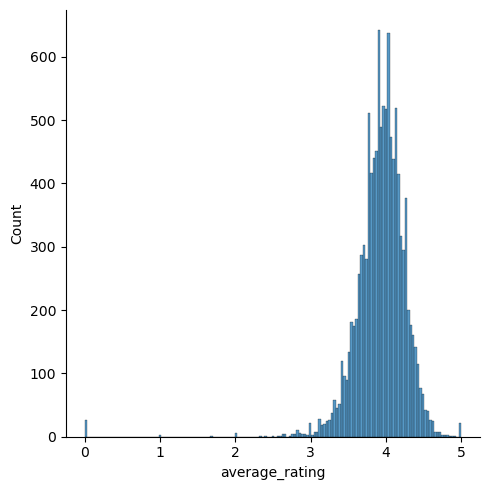

In [7]:
# draw distribution of ratings
sns.displot(df.average_rating)

#### --> Average rating seems to be normal distribution

### Plotting normalized values on '0-1' scale for: average_rating (1), num_pages (2), ratings_count (3), reviews_count (4)

<function matplotlib.pyplot.show(close=None, block=None)>

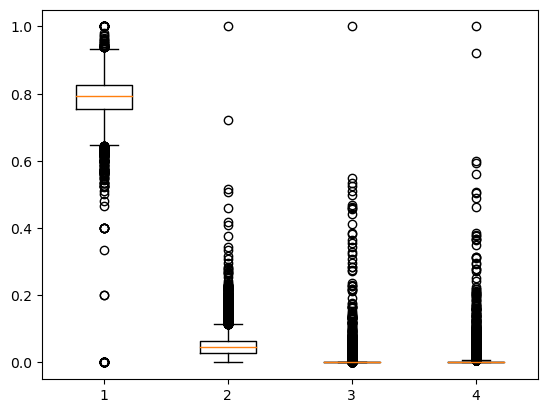

In [8]:
normalizedVars = df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']].values.astype(float)
#myUnitScale = preprocessing.MinMaxScaler()
myNormVar=preprocessing.MinMaxScaler().fit_transform(normalizedVars)
plt.boxplot(myNormVar)
plt.show

spread of data and outliers are shown above

may need to focus analysis on specific ranges

### Categorical data

In [ ]:
df.language_code.value_counts() # distribution / frequency of the classes "language_code"

In [9]:
catcols = ['title', 'authors', 'isbn', 'language_code','publication_date','publisher']
df[catcols].describe()

,title,authors,isbn,language_code,publication_date,publisher
count,11127,11127,11127,11127,11127,11127
unique,10352,6643,11127,27,3679,2292
top,The Brothers Karamazov,Stephen King,439785960,eng,10/1/2005,Vintage
freq,9,40,1,8911,56,318


In [16]:
df.loc[df.title=='The Brothers Karamazov',:].average_rating.describe()

count    9.00
mean     4.32
std      0.00
min      4.32
25%      4.32
50%      4.32
75%      4.32
max      4.32
Name: average_rating, dtype: float64

In [15]:
df.loc[df.authors=='Stephen King',:].average_rating.describe()

count    40.000000
mean      3.973500
std       0.270067
min       3.320000
25%       3.882500
50%       3.965000
75%       4.175000
max       4.540000
Name: average_rating, dtype: float64

In [17]:
df.loc[df.publisher=='Vintage',:].average_rating.describe()

count    318.000000
mean       3.894182
std        0.259305
min        2.790000
25%        3.750000
50%        3.910000
75%        4.077500
max        4.530000
Name: average_rating, dtype: float64

top book is "the brothers Karamazov"

top author Stephen King

most cited publisher = Vintage

## Clean and structure data

### COMMENTS

1) Average Rating "describe()" showed MEDIAN=3.96 (~normal distribution)

2) Creating low medium high rating class ??

3) Strong Correlation btw ratings_count and reviews_count : DROP REVIEWS?

3) deal with outliers in other columns (rating, num_pages, text_reviews)

4) consider including categorical data for more accurate prediction (to sort / encode)

In [18]:
# df1_processed['average_rating'] = df1_processed['average_rating'].astype('int')
df1=df.drop(columns=['text_reviews_count'])

In [19]:
df1.average_rating.describe() # 

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64

### Create low, med, high categories for average_rating

In [20]:
# group_name: upper bound
groups = {'0LOW': 0, '1MEDIUM': 3, '2HIGH': 4}
df1['R_Type'] = pd.cut(df1['average_rating'], right = False,
                    bins=list(groups.values())+[float('inf')],
                    labels=list(groups),include_lowest = True
                   )
#bins = np.linspace(min(df1['average_rating']), max(df1['average_rating']),4)
#groupNames = ["low", "med", "high"]
#df1['RatingCat'] = pd.cut(df1['average_rating'], bins, labels = groupNames, include_lowest = True)

In [21]:
df1['R_Type'].describe()

count       11127
unique          3
top       1MEDIUM
freq         6088
Name: R_Type, dtype: object

In [22]:
df1['R_Type'].value_counts()

1MEDIUM    6088
2HIGH      4954
0LOW         85
Name: R_Type, dtype: int64

In [23]:
df1.shape

(11127, 11)

In [187]:
df1.describe()

,average_rating,isbn13,num_pages,ratings_count
count,11127.000000,1.112700e+04,11127.000000,1.112700e+04
mean,3.933631,9.759888e+12,336.376921,1.793641e+04
std,0.352445,4.428964e+11,241.127305,1.124794e+05
min,0.000000,8.987060e+09,0.000000,0.000000e+00
25%,3.770000,9.780350e+12,192.000000,1.040000e+02
50%,3.960000,9.780590e+12,299.000000,7.450000e+02
75%,4.135000,9.780870e+12,416.000000,4.993500e+03
max,5.000000,9.790010e+12,6576.000000,4.597666e+06


In [24]:
myLabel = preprocessing.LabelEncoder()
df1['R_Type'] = myLabel.fit_transform(df1['R_Type'])

In [ ]:
df1.tail()

In [25]:
df1['R_Type'].value_counts()

1    6088
2    4954
0      85
Name: R_Type, dtype: int64

In [26]:
df1[df1['R_Type']==0].describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,85.000000,8.500000e+01,85.000000,85.000000,85.0
mean,1.821765,9.666790e+12,263.000000,768.211765,0.0
std,1.268412,1.055607e+12,204.365219,3024.876546,0.0
min,0.000000,4.908601e+10,0.000000,0.000000,0.0
25%,0.000000,9.780410e+12,128.000000,0.000000,0.0
50%,2.620000,9.780790e+12,241.000000,3.000000,0.0
75%,2.830000,9.781400e+12,324.000000,36.000000,0.0
max,2.990000,9.789030e+12,1088.000000,23409.000000,0.0


In [27]:
df1[df1['R_Type']==1].describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,6088.000000,6.088000e+03,6088.000000,6.088000e+03,6088.0
mean,3.754391,9.761200e+12,309.258377,1.508913e+04,1.0
std,0.192501,4.251211e+11,174.778206,1.086183e+05,0.0
min,3.000000,2.004913e+10,0.000000,0.000000e+00,1.0
25%,3.650000,9.780340e+12,197.000000,9.900000e+01,1.0
50%,3.800000,9.780550e+12,288.000000,6.825000e+02,1.0
75%,3.900000,9.780820e+12,384.000000,4.241250e+03,1.0
max,3.990000,9.789880e+12,1952.000000,4.597666e+06,1.0


In [28]:
df1[df1['R_Type']==2].describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,4954.000000,4.954000e+03,4954.000000,4.954000e+03,4954.0
mean,4.190135,9.759873e+12,370.962051,2.173001e+04,2.0
std,0.156107,4.466276e+11,300.272831,1.178595e+05,0.0
min,4.000000,8.987060e+09,0.000000,0.000000e+00,2.0
25%,4.070000,9.780370e+12,192.000000,1.220000e+02,2.0
50%,4.160000,9.780670e+12,314.000000,8.735000e+02,2.0
75%,4.270000,9.780940e+12,465.000000,6.133000e+03,2.0
max,5.000000,9.790010e+12,6576.000000,2.530894e+06,2.0


### Top 10 Books that received more ratings

In [ ]:
# Let's look at the top 10 rated books
top10Books = df1.nlargest(10, ['ratings_count']).set_index('title')['ratings_count']
plot_dims = (12, 8)
fig, ax = plt.subplots(figsize=plot_dims)
sns.barplot(x=top10Books, y=top10Books.index)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 15, color = 'k')
    
plt.show()

### Top 10 book titles vs number of pages

In [ ]:
# Let's look at the top 10 books in terms of number of pages
top10Books2 = df1.nlargest(10, ['num_pages']).set_index('title')['num_pages']
plot_dims = (12, 8)
fig, ax = plt.subplots(figsize=plot_dims)
sns.barplot(x=top10Books2, y=top10Books2.index)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 15, color = 'k')
    
plt.show()

### Average_ratings vs num_pages

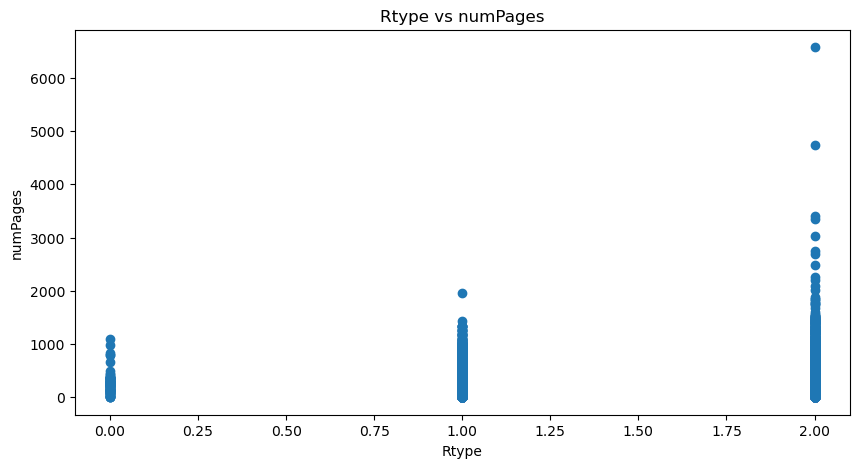

In [74]:
# plot avg rating vs num pages
plt.figure(figsize=(10,5))
plt.scatter(df1.R_Type,df.num_pages)
plt.title("Rtype vs numPages")
plt.xlabel("Rtype")
plt.ylabel("numPages")
plt.show()

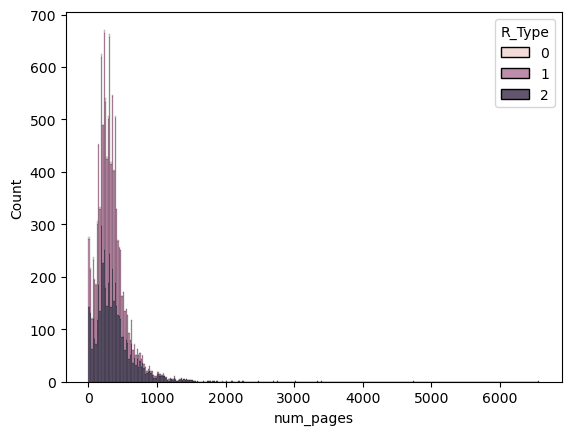

In [75]:
sns.histplot(x="num_pages",hue="R_Type",multiple="stack",data=df1)
plt.show()

In [78]:
NormNumPage = df1.num_pages / max(df1.num_pages)
NormRatingCnt = df1.ratings_count / max(df1.ratings_count)
#sns.jointplot(data=df1, x="num_pages", y="ratings_count", hue="R_Type") 

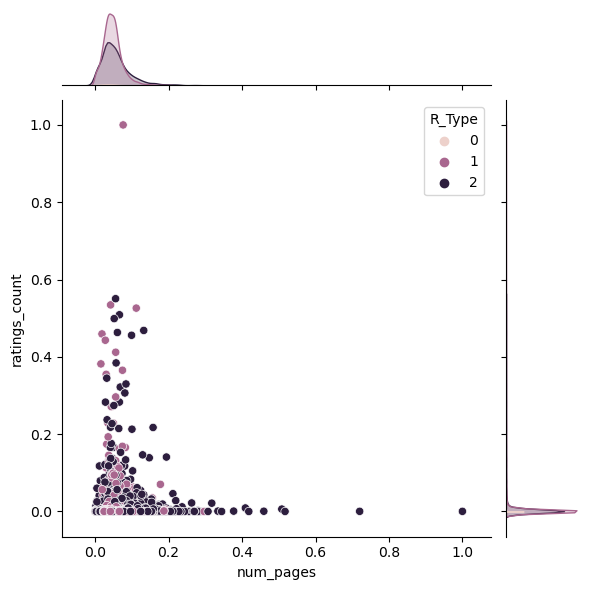

In [79]:
sns.jointplot(data=df1, x=NormNumPage, y=NormRatingCnt, hue="R_Type") 

In [80]:
mydf=df1.drop(columns=['isbn13'])

In [81]:
mydf['NormNumPage']=NormNumPage

In [82]:
mydf['NormRatingCnt']=NormRatingCnt

In [83]:
mydf=mydf.drop(columns=['num_pages', 'ratings_count'])

In [84]:
mydf.describe()

,average_rating,R_Type,NormNumPage,NormRatingCnt
count,11127.000000,11127.000000,11127.000000,11127.000000
mean,3.933631,1.437584,0.051152,0.003901
std,0.352445,0.511279,0.036668,0.024464
min,0.000000,0.000000,0.000000,0.000000
25%,3.770000,1.000000,0.029197,0.000023
50%,3.960000,1.000000,0.045468,0.000162
75%,4.135000,2.000000,0.063260,0.001086
max,5.000000,2.000000,1.000000,1.000000


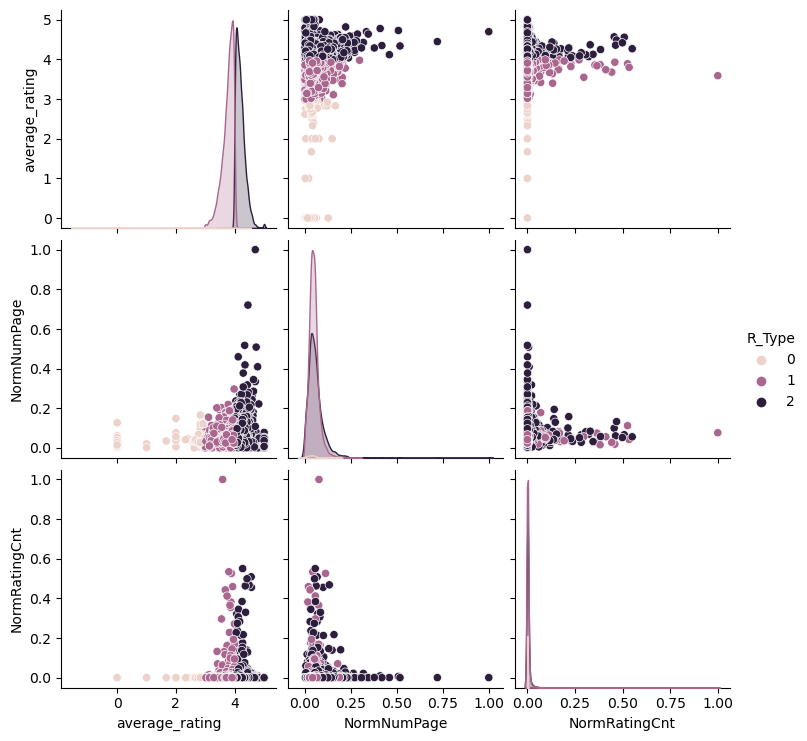

In [85]:
sns.pairplot(data=mydf, hue="R_Type")

### Language Code sorting

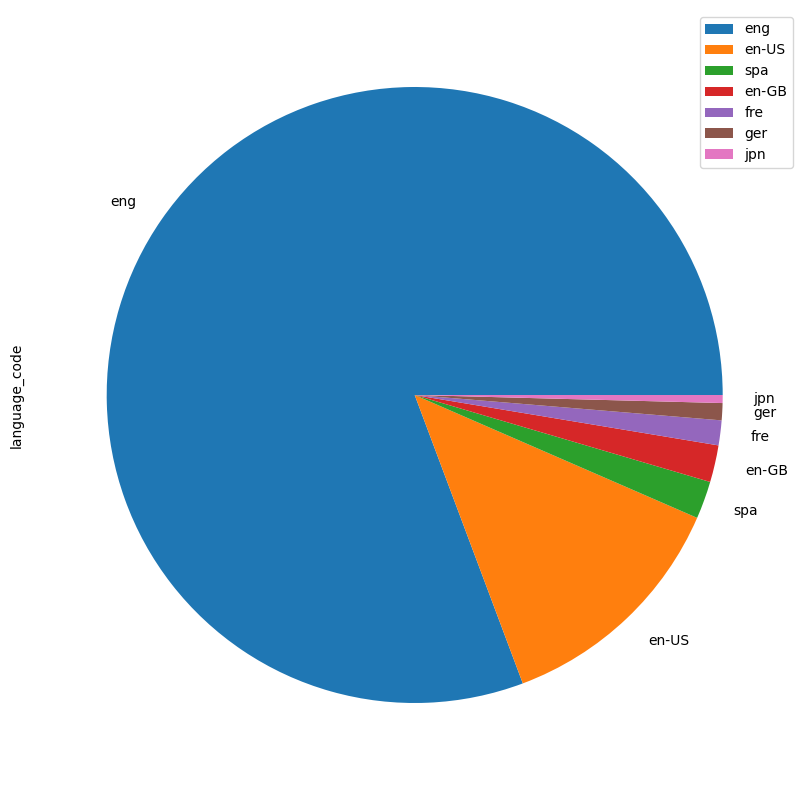

In [86]:
df1['language_code'].value_counts().head(7).plot(kind = 'pie', figsize=(10, 10)).legend()
plt.show()

In [29]:
df_LangCode = df1.loc[df1['language_code'].isin(['eng','en-US', 'spa', 'en-GB', 'fre'])] 
df_LangCode.shape

(10896, 11)

### Creating two numpages samples based on LangCode subset

In [30]:
# books that are counted as having more than 500 pages
max_numpages = 500
df1_max_numpages = df_LangCode.drop(df_LangCode.index[df_LangCode['num_pages'] <= max_numpages])

In [31]:
df1_max_numpages.shape

(1689, 11)

In [32]:
## books that are counted as having less than 500 pages
df1_std_numpages = df_LangCode.drop(df_LangCode.index[df_LangCode['num_pages'] > max_numpages])

In [33]:
df1_std_numpages.shape

(9207, 11)

In [34]:
df1_max_numpages.describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,1689.000000,1.689000e+03,1689.000000,1.689000e+03,1689.000000
mean,4.055110,9.753289e+12,738.547069,2.477169e+04,1.615749
std,0.288469,5.053439e+11,322.958686,1.660652e+05,0.493813
min,0.000000,7.399925e+10,501.000000,0.000000e+00,0.000000
25%,3.900000,9.780310e+12,560.000000,1.560000e+02,1.000000
50%,4.070000,9.780470e+12,645.000000,1.031000e+03,2.000000
75%,4.240000,9.780770e+12,801.000000,7.506000e+03,2.000000
max,5.000000,9.789690e+12,6576.000000,4.597666e+06,2.000000


In [35]:
df1_std_numpages.describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,9207.000000,9.207000e+03,9207.000000,9.207000e+03,9207.000000
mean,3.908577,9.760497e+12,262.316607,1.712091e+04,1.401325
std,0.353789,4.361422e+11,121.127375,1.010775e+05,0.506969
min,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,3.750000,9.780350e+12,182.000000,1.090000e+02,1.000000
50%,3.930000,9.780590e+12,264.000000,7.620000e+02,1.000000
75%,4.110000,9.780870e+12,352.000000,4.849500e+03,2.000000
max,5.000000,9.790010e+12,500.000000,2.530894e+06,2.000000


## Encoding the Categorical variables for the two samples

### a. Encode the 'title' (label encoding --> numbers)

#### Encoding samples in df1_max_numpages and df1_std_numpages:

In [36]:
# encode title column
labelEncode = preprocessing.LabelEncoder()
df1_max_numpages['title'] = labelEncode.fit_transform(df1_max_numpages['title'])
df1_std_numpages['title'] = labelEncode.fit_transform(df1_std_numpages['title'])

In [93]:
df1_max_numpages.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,publication_date,publisher,R_Type
bookID,,,,,,,,,,,
1,433,J.K. Rowling/Mary GrandPré,4.57,439785960,9780440000000,eng,652,2095690,9/16/2006,Scholastic Inc.,2
2,434,J.K. Rowling/Mary GrandPré,4.49,439358078,9780440000000,eng,870,2153167,9/1/2004,Scholastic Inc.,2
8,430,J.K. Rowling/Mary GrandPré,4.78,439682584,9780440000000,eng,2690,41428,9/13/2004,Scholastic,2
10,431,J.K. Rowling,4.73,439827604,9780440000000,eng,3342,28242,9/12/2005,Scholastic,2
12,1381,Douglas Adams,4.38,517226952,9780520000000,eng,815,3628,11/1/2005,Gramercy Books,2


In [ ]:
df1_std_numpages.head()

### b. Encode the 'authors'  (label encoding --> numbers)

#### Encoding samples in df1_max_numpages and df1_std_numpages

In [37]:
# encode authors column
df1_max_numpages['authors'] = labelEncode.fit_transform(df1_max_numpages['authors'])
df1_std_numpages['authors'] = labelEncode.fit_transform(df1_std_numpages['authors'])

In [ ]:
df1_max_numpages.head()

In [ ]:
df1_std_numpages.head()

### c. Dummy encode the 'language_code' (one-hot encoding --> vectors)

#### Encoding samples in df1_max_numpages

In [38]:
encoded_lang_max = pd.get_dummies(df1_max_numpages['language_code'])
colsExist2 = df1_max_numpages.columns.isin(['en-US', 'eng', 'en-GB', 'fre', 'spa']).any()
if  colsExist2 == False:
    df1_max_numpages = pd.concat([df1_max_numpages, encoded_lang_max], axis = 1)
print(df1_max_numpages.shape)
df1_max_numpages.head()

(1689, 16)


,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,publication_date,publisher,R_Type,en-GB,en-US,eng,fre,spa
bookID,,,,,,,,,,,,,,,,
1,433,517,4.57,439785960,9780440000000,eng,652,2095690,9/16/2006,Scholastic Inc.,2,0,0,1,0,0
2,434,517,4.49,439358078,9780440000000,eng,870,2153167,9/1/2004,Scholastic Inc.,2,0,0,1,0,0
8,430,517,4.78,439682584,9780440000000,eng,2690,41428,9/13/2004,Scholastic,2,0,0,1,0,0
10,431,515,4.73,439827604,9780440000000,eng,3342,28242,9/12/2005,Scholastic,2,0,0,1,0,0
12,1381,269,4.38,517226952,9780520000000,eng,815,3628,11/1/2005,Gramercy Books,2,0,0,1,0,0


#### Encoding samples in df1_std_numpages

In [39]:
encoded_lang_std = pd.get_dummies(df1_std_numpages['language_code'])
colsExist2 = df1_std_numpages.columns.isin(['en-US', 'eng', 'en-GB', 'fre', 'spa']).any()
if  colsExist2 == False:
    df1_std_numpages = pd.concat([df1_std_numpages, encoded_lang_std], axis = 1)
print(df1_std_numpages.shape)
df1_std_numpages.head()

(9207, 16)


,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,publication_date,publisher,R_Type,en-GB,en-US,eng,fre,spa
bookID,,,,,,,,,,,,,,,,
4,2570,2204,4.42,439554896,9780440000000,eng,352,6333,11/1/2003,Scholastic,2,0,0,1,0,0
5,2571,2205,4.56,043965548X,9780440000000,eng,435,2339585,5/1/2004,Scholastic Inc.,2,0,0,1,0,0
9,8161,5430,3.74,976540606,9780980000000,en-US,152,19,4/26/2005,Nimble Books,1,0,1,0,0,0
14,6585,1268,4.22,1400052920,9781400000000,eng,215,4930,8/3/2004,Crown,2,0,0,1,0,0
16,6585,1273,4.22,739322206,9780740000000,eng,6,1266,3/23/2005,Random House Audio,2,0,0,1,0,0


## Model selection (next) - refer "titanic project"

In [40]:
# create subset df_processed for numeric data only & drop unused columns 
df1_max_numpages = df1_max_numpages.drop(columns=["average_rating", "isbn","language_code", "publication_date","publisher"])

In [ ]:
df1_max_numpages

In [41]:
# create subset df_processed for numeric data only & drop unused columns 
df1_std_numpages = df1_std_numpages.drop(columns=["average_rating", "isbn","language_code", "publication_date","publisher"])

In [ ]:
df1_std_numpages

In [42]:
df1_std_numpages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9207 entries, 4 to 45641
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   title          9207 non-null   int32
 1   authors        9207 non-null   int32
 2   isbn13         9207 non-null   int64
 3   num_pages      9207 non-null   int64
 4   ratings_count  9207 non-null   int64
 5   R_Type         9207 non-null   int32
 6   en-GB          9207 non-null   uint8
 7   en-US          9207 non-null   uint8
 8   eng            9207 non-null   uint8
 9   fre            9207 non-null   uint8
 10  spa            9207 non-null   uint8
dtypes: int32(3), int64(3), uint8(5)
memory usage: 440.6 KB


In [44]:
df1_std_numpages['R_Type'].value_counts()

1    5358
2    3772
0      77
Name: R_Type, dtype: int64

### Model selection

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# " define (randomly) training and testing dataframe"
df_train_std, df_test_std = train_test_split(df1_std_numpages,test_size = 0.2, stratify = df1_std_numpages.R_Type)

In [47]:
len(df1_std_numpages)

9207

In [48]:
len(df_train_std)

7365

In [49]:
len(df_test_std)

1842

In [ ]:
# option to write a function to apply model
'''
def ModelBuilding_LogisticRegression(df_Current, testSize=0.2):
    # divide the data into attributes and labels
    X = df_Current.drop(['R_Type'], axis = 1)
    y = df_Current['R_Type']
    print("Shape of Inputs = {0}".format(X.shape))
    print("Shape of Target = {0}".format(y.shape))
    # split 80% of the data to the training set and 20% of the data to test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 999)
    logReg = LogisticRegression()
    logReg.fit(X_train, y_train)
    print("Intercept = {0}".format(linReg.intercept_))
    print("Coefficients = {0}".format(linReg.coef_.tolist()))
    predictions = linReg.predict(X_test)
    return (predictions, X_test, y_test, linReg)
'''

In [50]:
df_train_std

,title,authors,isbn13,num_pages,ratings_count,R_Type,en-GB,en-US,eng,fre,spa
bookID,,,,,,,,,,,
40452,858,4449,9780790000000,144,617,1,0,0,1,0,0
2386,3883,2047,9789630000000,25,67,1,0,0,1,0,0
36425,5641,1172,9780760000000,39,3,2,0,0,1,0,0
14688,2930,3291,9780140000000,432,605,2,0,0,1,0,0
13485,7877,1839,9780310000000,172,115,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4764,5262,4574,9780680000000,400,55,1,0,1,0,0,0
17581,4539,5507,9780060000000,32,440,2,0,0,1,0,0
32508,5814,3711,9780450000000,482,125864,2,0,0,1,0,0


In [51]:
print(df1_std_numpages.R_Type.mean())
print(df_train_std.R_Type.mean())
print(df_test_std.R_Type.mean())

1.4013250787444336
1.4012219959266803
1.4017372421281216


In [52]:
df1_std_numpages.R_Type.describe()

count    9207.000000
mean        1.401325
std         0.506969
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: R_Type, dtype: float64

In [53]:
df_train_std.columns

Index(['title', 'authors', 'isbn13', 'num_pages', 'ratings_count', 'R_Type',
       'en-GB', 'en-US', 'eng', 'fre', 'spa'],
      dtype='object')

In [54]:
# get the values of the columns for the training data
X_train = df_train_std.loc[:,['title', 'authors', 'isbn13', 'num_pages', 'ratings_count', 'en-GB', 'en-US', 'eng', 'fre', 'spa']].values
y_train = df_train_std.R_Type.values

In [55]:
# get the values of the columns for the training data
X_test = df_test_std.loc[:,['title', 'authors', 'isbn13', 'num_pages', 'ratings_count', 'en-GB', 'en-US', 'eng', 'fre', 'spa']].values
y_test = df_test_std.R_Type.values

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
# here we initialize the model
lr_model = LogisticRegression(random_state=0,max_iter=1000) # random_state=0 or 42... means 
# ...i want the same conditions if i re-use the model again

In [58]:
# here we train the model on the training data
lr_model.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [59]:
y_test_predicted = lr_model.predict(X_test) # list of prediction my model will make

In [60]:
y_test_predicted

array([1, 1, 1, ..., 1, 1, 1])

In [61]:
y_test

array([1, 2, 2, ..., 2, 2, 1])

In [62]:
(y_test_predicted == y_test).sum()/len(y_test)

0.5819761129207384

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1","y_test_2"],index=["y_pred_0","y_pred_1","y_pred_2"]
)

In [65]:
cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_predicted)

In [66]:
cf

,y_test_0,y_test_1,y_test_2
y_pred_0,0,15,0
y_pred_1,0,1072,0
y_pred_2,0,755,0


In [67]:
cf/len(y_test)

,y_test_0,y_test_1,y_test_2
y_pred_0,0.0,0.008143,0.0
y_pred_1,0.0,0.581976,0.0
y_pred_2,0.0,0.409881,0.0


In [68]:
y_test

array([1, 2, 2, ..., 2, 2, 1])